<a href="https://colab.research.google.com/github/Matvezy/Body-Mesurments/blob/master/TorchFRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
# import necessary libraries
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import torch
import numpy as np
import cv2
import random
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# get the pretrained model from torchvision.models
# Note: pretrained=True will get the pretrained weights for the model.
# model.eval() to use the model for inference
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()


def random_colour_masks(image):
  """
  random_colour_masks
    parameters:
      - image - predicted masks
    method:
      - the masks of each predicted object is given random colour for visualization
  """
  colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
  coloured_mask = np.stack([r, g, b], axis=2)
  return coloured_mask

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person'
]

def get_prediction(img_path, threshold):
  """
  get_prediction
    parameters:
      - img_path - path of the input image
    method:
      - Image is obtained from the image path
      - the image is converted to image tensor using PyTorch's Transforms
      - image is passed through the model to get the predictions
      - masks, classes and bounding boxes are obtained from the model and soft masks are made binary(0 or 1) on masks
        ie: eg. segment of cat is made 1 and rest of the image is made 0
    
  """
  img = Image.open(img_path)
  transform = T.Compose([T.ToTensor()])
  img = transform(img)
  pred = model([img])
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
  masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
  masks = masks[:pred_t+1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return masks, pred_boxes, pred_class


def instance_segmentation_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
  """
  instance_segmentation_api
    parameters:
      - img_path - path to input image
    method:
      - prediction is obtained by get_prediction
      - each mask is given random color
      - each mask is added to the image in the ration 1:0.8 with opencv
      - final output is displayed
  """
  masks, boxes, pred_cls = get_prediction(img_path, threshold)
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  for i in range(len(masks)):
    rgb_mask = random_colour_masks(masks[i])
    img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
    cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
  plt.figure(figsize=(20,30))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


In [3]:
def findppm(mask, height):
  masklen = len(mask) - 1
  trig1 = False
  trig2 = False
  trig3 = False
  trig4 = False
  while masklen >= 0:
    for j in mask[masklen]:
      if j == 1:
        trig1 = True
        break
    if trig1:
      break
    masklen -= 1

  topix = 0
  while topix < len(mask):
    for j in mask[topix]:
      if j == 1:
        trig2 = True
        break
    if trig2:
      break 
    topix += 1

  left = 0
  for i in range(len(mask[0])):
    for j in range((len(mask))):
      if mask[j][i] == 1:
        left = mask[j][i]
        trig4 = True
        break
    if trig4:
      break

  right = len(mask[0]) - 1
  while right >= 0:
    for j in range(len(mask)-1):
      if mask[j][right] == 1:
        trig3 = True
        break
    if trig3:
      break
    right -= 1
  return masklen, topix, left, right

In [4]:
colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]

a,b,c=colours[0]

In [5]:
img = Image.open('/content/gdrive/MyDrive/Front.png')
transform = T.Compose([T.ToTensor()])
img = transform(img)
if img.size()[0] == 4:
        img = img[:3, ...] 
pred = model([img])

In [6]:
img.shape

torch.Size([3, 666, 375])

In [7]:
labels = pred[0]['labels'].detach().numpy()
scores = pred[0]['scores'].detach().numpy()
indh = np.where(labels == 1)
needed = np.where(scores[indh] > 0.8)
masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
mask = masks[needed].astype('int')[0]

boxes = pred[0]['boxes'].detach().numpy()
box = boxes[needed].astype('int')[0]

In [8]:
height = 164

In [9]:
bottom, top, left, right = findppm(mask, height)

In [10]:
ppm_std = 2.56

In [11]:
req_pixheight = int(ppm_std * height)

In [112]:
import matplotlib.image as mpimg
image=mpimg.imread('/content/gdrive/MyDrive/Front.png')
image = image[top:bottom,box[0]:box[2]]
req_width = int((req_pixheight * image.shape[1])/image.shape[0])

In [113]:
import torchvision.transforms.functional as TF
image = Image.fromarray((image* 255).astype(np.uint8))
image = TF.resize(image, (req_pixheight, req_width))

In [114]:
alpha = image.split()[-1]

In [115]:
print(alpha)

<PIL.Image.Image image mode=L size=268x419 at 0x7FD189F5B6A0>


In [116]:
alpha = np.array(alpha)

In [117]:
width = len(alpha[0])
height = len(alpha)
midpoint_w = 0
dist_h = 0

if width < 512:
  dist_w = 512 - width
  midpoint_w = int(dist_w/2)
if height < 512:
  dist_h = 512 - height

alpha = np.pad(alpha, ((dist_h, 0),(midpoint_w, midpoint_w)), 'constant')
alpha = Image.fromarray(alpha)

In [118]:
alpha_image = Image.merge('RGB', (alpha, alpha, alpha))

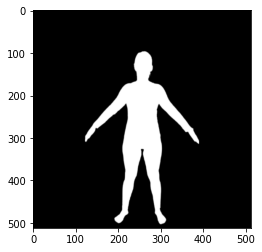

In [119]:
plt.imshow(alpha_image)
plt.show()